<a href="https://colab.research.google.com/github/segadamyan/Garbage-Classification/blob/main/Garbage_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
from PIL import Image as im
from sklearn.model_selection import train_test_split
import keras
#from tf.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import os
import time
import seaborn as sns
from tensorflow.keras.models import Sequential
import numpy as np

In [ ]:
import random
def seed_everything(seed = 0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed = 0
seed_everything(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BATCH_SIZE = 64
img_height = 244
img_width = 244
     

In [ ]:
import os
data_path = '/content/drive/MyDrive/Colab Notebooks/Garbage Classification/Data'
os.listdir(data_path)

['train', 'test', 'experiment']

In [ ]:
input_path = data_path
train_data_dir = input_path + '/' + 'train'
test_data_dir = input_path + '/' + 'test'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split = 0.2,
    subset = 'training',
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE,
    seed = 11)

Found 2187 files belonging to 7 classes.
Using 1750 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split = 0.2,
    subset = 'validation',
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE,
    seed = 11)

Found 2187 files belonging to 7 classes.
Using 437 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']


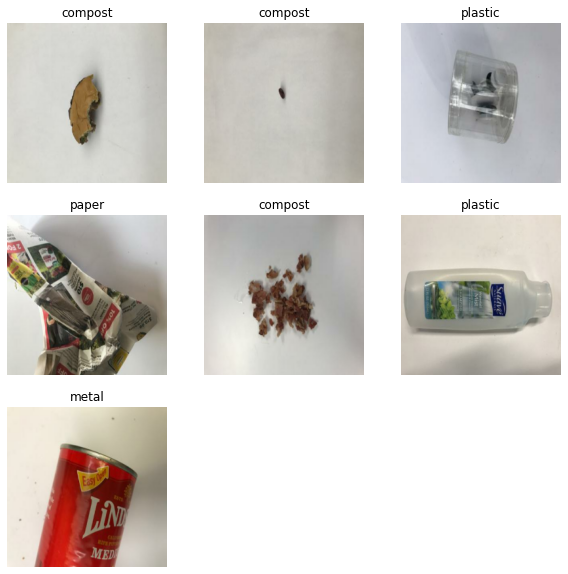

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(len(class_names)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential([
    #layers.CenterCrop(125, 125),
    keras.layers.RandomFlip('horizontal', input_shape = (img_height, img_width, 3)),
    keras.layers.RandomRotation(0.2, fill_mode = 'nearest'),
])

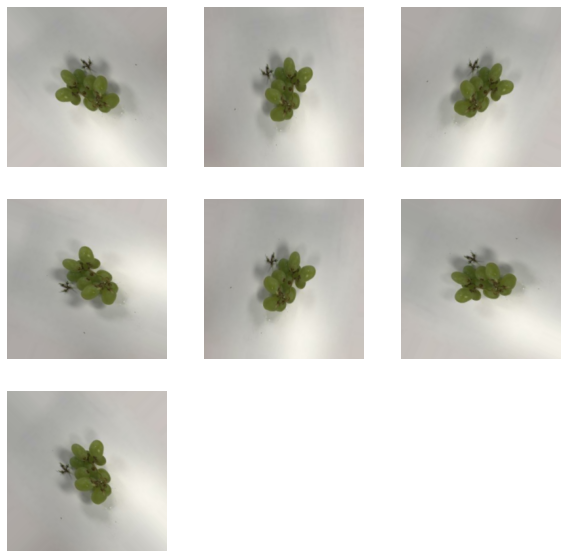

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(len(class_names)):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_height, img_width, 3)
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet')
base_model.trainable = False
base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                              

In [ ]:
def print_layer_trainable():
    for layer in base_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [ ]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [ ]:
base_model.trainable = False

In [ ]:
for layer in base_model.layers:
  if 'block5_conv' in layer.name: 
    layer.trainable = True

In [ ]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
False:	block5_pool


In [ ]:
n_classes = len(class_names)

model = Sequential([
    data_augmentation,
    keras.layers.Rescaling(1./255),
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(n_classes, activation = 'softmax')
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 244, 244, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 244, 244, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
# Model Chackpoint
tl_checkpoint_1 = keras.callbacks.ModelCheckpoint(filepath = 'vgg16_best_weights.hdf5', save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, mode = 'min')

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000001)

In [ ]:
history = model.fit(train_ds,
                    epochs = 50,
                    validation_data = val_ds,
                    callbacks = [tl_checkpoint_1, early_stop, rop_callback])

Epoch 1/50


28/28 [==============================] - 187s 6s/step - loss: 1.7553 - accuracy: 0.3177 - val_loss: 1.4635 - val_accuracy: 0.4439 - lr: 0.0100
Epoch 2/50
28/28 [==============================] - 16s 571ms/step - loss: 1.3308 - accuracy: 0.4537 - val_loss: 1.1897 - val_accuracy: 0.4851 - lr: 0.0100
Epoch 3/50
28/28 [==============================] - 16s 580ms/step - loss: 1.1759 - accuracy: 0.5126 - val_loss: 1.0010 - val_accuracy: 0.5995 - lr: 0.0100
Epoch 4/50
28/28 [==============================] - 16s 579ms/step - loss: 1.1185 - accuracy: 0.5571 - val_loss: 1.0375 - val_accuracy: 0.5812 - lr: 0.0100
Epoch 5/50
28/28 [==============================] - 16s 581ms/step - loss: 1.0605 - accuracy: 0.5806 - val_loss: 0.9189 - val_accuracy: 0.6773 - lr: 0.0100
Epoch 6/50
28/28 [==============================] - 16s 576ms/step - loss: 1.0186 - accuracy: 0.5931 - val_loss: 0.9363 - val_accuracy: 0.6384 - lr: 0.0100
Epoch 7/50
28/28 [==============================] - 16s 584ms/step - loss: 0.

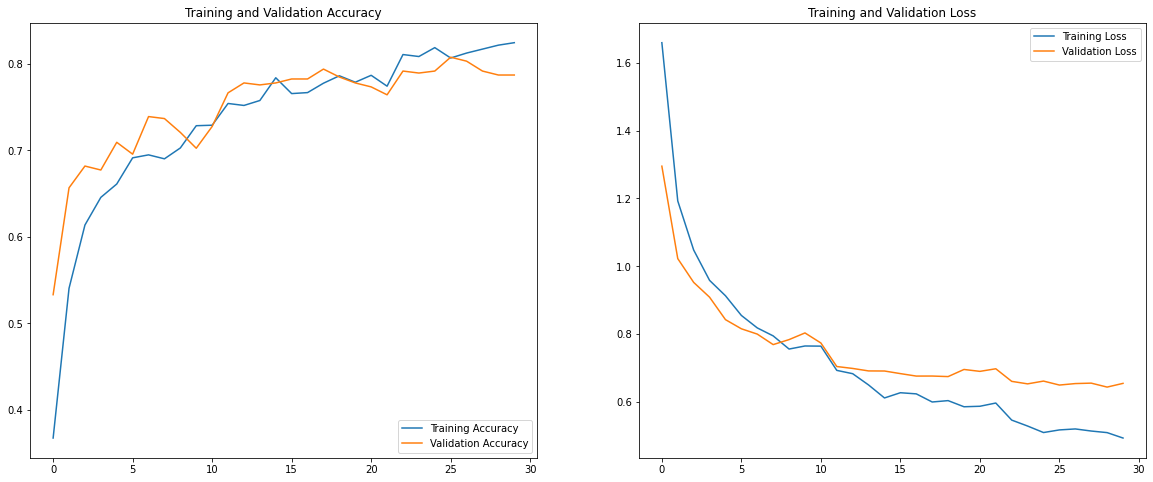

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = 1,
    seed = 11)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 564 files belonging to 7 classes.


In [ ]:
# Generate predictions
# model.load_weights('/content/vgg16_best_weights.hdf5') # initialize the best trained weights
preds = model.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

564/564 [==============================] - 171s 297ms/step


In [ ]:
model.evaluate(test_ds, verbose = 1)

261/564 [============>.................] - ETA: 3s - loss: 0.7421 - accuracy: 0.7356

In [ ]:
experiment = input_path + '/' + 'experiment'

In [ ]:
experoment_ds = tf.keras.utils.image_dataset_from_directory(
    experiment,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = 1,
    seed = 123)

Found 1 files belonging to 1 classes.


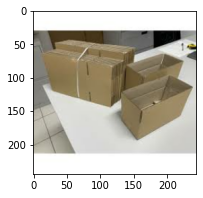

In [ ]:
plt.figure(figsize=(3, 3))

for images, _ in experoment_ds.take(1):
  plt.imshow(images[0].numpy().astype("uint8"))

In [ ]:
experiment_pred = model2.predict(experoment_ds.take(1))

1/1 [==============================] - 0s 137ms/step


In [ ]:
print(class_names[np.argmax(experiment_pred, axis = 1)[0]])

cardboard


In [ ]:
class_names

['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
model2.evaluate(test_ds, verbose = 1)

564/564 [==============================] - 7s 12ms/step - loss: 0.9075 - accuracy: 0.7411


[0.9074795246124268, 0.741134762763977]